# Install and import libraries

In [20]:
%pip install pydot
%pip install tensorflow
%pip install scikit-learn
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   - -------------------------------------- 5.8/124.9 MB 44.0 MB/s eta 0:00:03
   ----- ---------------------------------- 16.5/124.9 MB 45.1 MB/s eta 0:00:03
   --------- ------------------------------ 28.6/124.9 MB 47.7 MB/s eta 0:00:03
   ------------- -------------------------- 41.2/124.9 MB 50.3 MB/s eta 0:00:02
   ---------------- ----------------------- 52.7/124.9 MB 50.8 MB/s eta 0:00:02
   -------------------- ------------------- 63.4/124.9 MB 51.2 MB/s eta 0:00:02
   ------------------------ --------------- 75.2/124.9 MB 51.6 MB/s eta 0:00:01
   --------------------------- ------------ 85.7/124.9 MB 51.6 MB/s eta 0:00:01
   ------------------------------- -------- 97.3/124.9 MB 51.3 MB/s eta 0:00:01
   --------------------------------- ----- 108.3/124.9 MB 51.2 MB/s eta 0:00:

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from xgboost import XGBClassifier

from pathlib import Path

from constants import (
    DATA_INPUT_PATH,
    CLASSES,
    MODEL_PATH,
    METADATA_PATH,
)

# Read the files in the data dir

In [11]:
# Read all of the files in the data folder
files_in_folder = Path(DATA_INPUT_PATH).rglob("*.csv")

files = [x for x in files_in_folder]
print([file for file in files])

[WindowsPath('data/7_4.csv'), WindowsPath('data/7_9_will.csv')]


## Convert .csv(s) to dataframes and concatenate

In [22]:
# Read the data from the files
dfs = []

for file in files:
    df = pd.read_csv(str(file))
    dfs.append(df)
        
# Convert the data to a DataFrame
df = pd.concat([x for x in dfs], axis=0)

# print(df.head())

# Before removing duplicates
print(f"Shape of dataframe before removing duplicates {df.shape}")
# Remove duplicates
df = df.drop_duplicates()
print(f"Shape of dataframe after removing duplicates {df.shape}")

# Print out the columns
# classes = {
#     "0": "unmarked",
#     "1": "rest",
#     "2": "clenched_fist",
#     "3": "wrist_flexion",
#     "4": "wrist_extension",
#     "5": "radial_deviations",
#     "6": "ulnar_deviations",
#     "7": "extended_palm"
# }

Shape of dataframe before removing duplicates (101633, 17)
Shape of dataframe after removing duplicates (101633, 17)


## Visualise the dataset

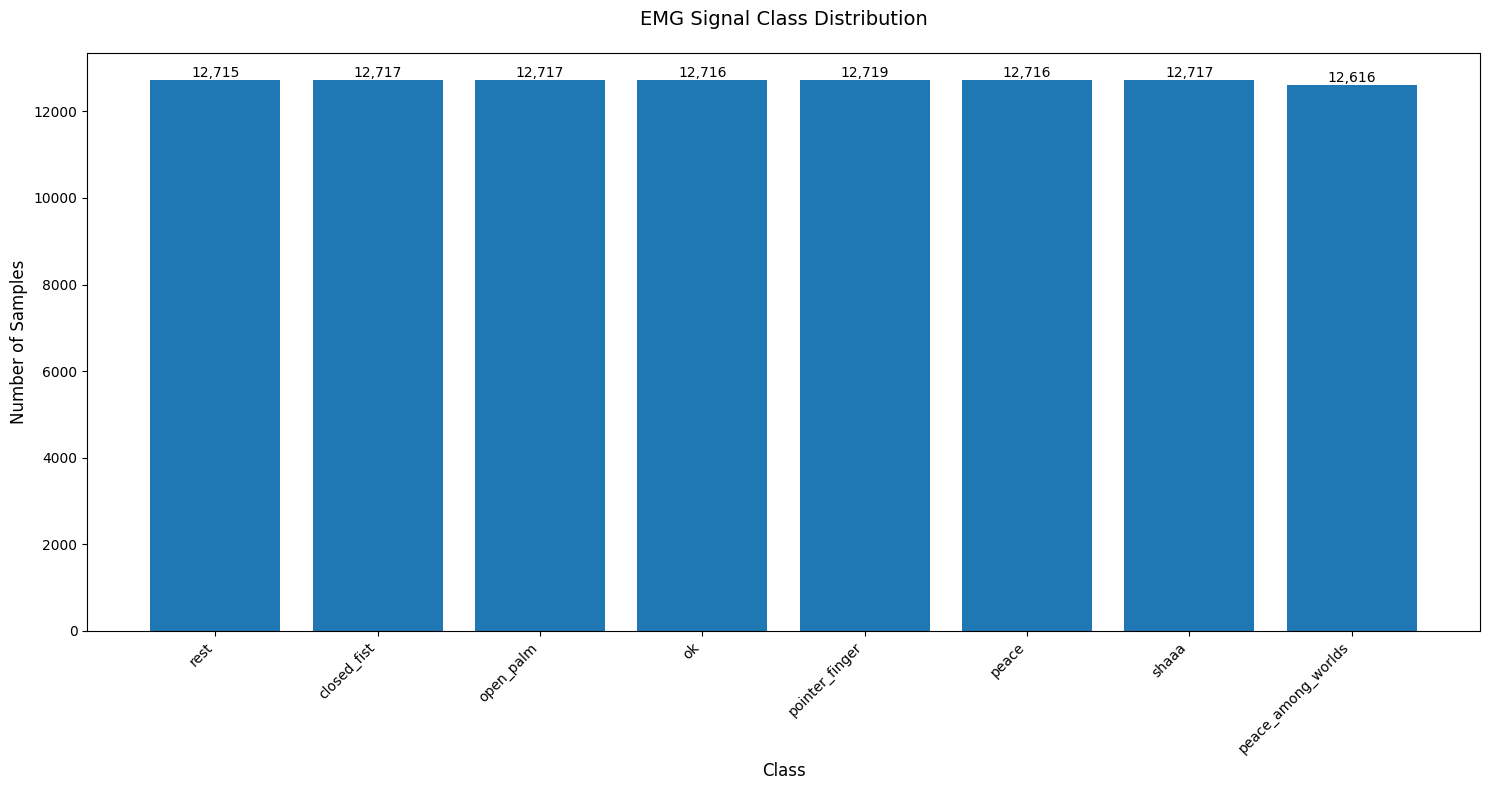

In [13]:
class_counts = df['Label'].value_counts().sort_index()

plt.figure(figsize=(15, 8))
bars = plt.bar(range(len(class_counts)), class_counts.values)

plt.title('EMG Signal Class Distribution', fontsize=14, pad=20)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)

# Set x-axis ticks with class labels
plt.xticks(range(len(class_counts)), [CLASSES[i] for i in range(len(class_counts))], rotation=45, ha='right')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [14]:
# # Group data by label and calculate mean for each sensor
# sensor_avgs = []
# sensor_stds = []

# for label in range(8):
#     label_data = df[df['Label'] == label].drop('Label', axis=1)
#     sensor_avgs.append(label_data.mean().values)
#     sensor_stds.append(label_data.std().values)

# sensor_avgs = np.array(sensor_avgs)
# sensor_stds = np.array(sensor_stds)

# # Set up the plot
# plt.figure(figsize=(15, 8))

# # Plot bars for each gesture
# x = np.arange(16)
# width = 0.1
# for i in range(8):
#     plt.bar(x + i*width, sensor_avgs[i], width, 
#             label=CLASSES[i],
#             yerr=sensor_stds[i],
#             capsize=2)

# # Customize the plot
# plt.xlabel('Sensor Number')
# plt.ylabel('Average Reading')
# plt.title('Average EMG Sensor Readings by Gesture')
# plt.xticks(x + width*4, [f'S{i+1}' for i in range(16)])
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

In [15]:
# # Set up the subplot grid for all 16 sensors x 8 classes
# fig, axs = plt.subplots(8, 16, figsize=(30, 20))
# fig.suptitle('EMG Sensor Data Distribution by Class and Sensor')

# bins = np.arange(-128, 129, 16) # Create bins from -128 to 128 in steps of 16

# for class_id, class_name in CLASSES.items():
#    class_data = df[df['Label'] == class_id]
   
#    for sensor in range(16):
#        sensor_col = f'Sensor{sensor+1}'
#        sensor_data = class_data[sensor_col]
       
#        axs[class_id, sensor].hist(sensor_data, bins=bins)
#        axs[class_id, sensor].set_title(f'{CLASSES[class_id]} - {sensor_col}')
       
#        # Only show y-axis labels for leftmost plots
#        if sensor != 0:
#            axs[class_id, sensor].set_yticklabels([])
           
#        # Only show x-axis labels for bottom plots
#        if class_id != 7:
#            axs[class_id, sensor].set_xticklabels([])

# plt.tight_layout()
# plt.show()

## Scale and clean the data, then train the model

In [19]:
X = df.drop(columns=['Label'])
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# filter for valid classes because the data is not clean
valid_classes = [0, 1, 2, 3, 4, 5, 6, 7]
mask_train = y_train.isin(valid_classes)
mask_test = y_test.isin(valid_classes)

# apply the mask to the training and testing data
X_train_filtered = X_train_scaled[mask_train]
y_train_filtered = y_train[mask_train]

X_test_filtered = X_test_scaled[mask_test]
y_test_filtered = y_test[mask_test]

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_filtered.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(8, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

start_sequential_time = time.time()
history = model.fit(X_train_filtered, y_train_filtered, 
                    epochs=100, 
                    batch_size=32, 
                    validation_split=0.2,
                    callbacks=[early_stopping])

test_loss, test_acc = model.evaluate(X_test_filtered, y_test_filtered)
end_sequential_time = time.time()
print(f"Test accuracy for sequential model: {test_acc}")
print(f"Time taken for sequential model: {end_sequential_time - start_sequential_time}")

c:\Users\willi\Desktop\Uni\3rd_year\NLP\CW1\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.2457 - loss: 1.9730 - val_accuracy: 0.4336 - val_loss: 1.5089
Epoch 2/100
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3895 - loss: 1.6035 - val_accuracy: 0.4776 - val_loss: 1.4008
Epoch 3/100
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.4250 - loss: 1.5208 - val_accuracy: 0.5114 - val_loss: 1.3488
Epoch 4/100
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4506 - loss: 1.4656 - val_accuracy: 0.5212 - val_loss: 1.3166
Epoch 5/100
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.4621 - loss: 1.4420 - val_accuracy: 0.5351 - val_loss: 1.3035
Epoch 6/100
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.4719 - loss: 1.4176 - val_accuracy: 0.5432 - val_loss: 1.2775
Epoch 7/100
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4800 - loss: 1.4095 - val_accuracy: 0.5496 - val_loss: 1.2781
Epoch 8/100
2033/2033 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4887 - lo

In [20]:
# Create and train the XGBoost model
start_xgb_time = time.time()
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_filtered, y_train_filtered)

# Evaluate the model
test_acc = xgb_model.score(X_test_filtered, y_test_filtered)
end_xgb_time = time.time()
print(f"Test accuracy using XGBoost: {test_acc}")
print(f"Time taken for XGBoost: {end_xgb_time - start_xgb_time}")

c:\Users\willi\Desktop\Uni\3rd_year\NLP\CW1\.conda\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:42:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test accuracy using XGBoost: 0.6393958774044375
Time taken for XGBoost: 277.4623034000397


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

start_rf_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_filtered, y_train_filtered)
end_rf_time = time.time()

y_pred_rf = rf_model.predict(X_test_filtered)
test_acc_rf = accuracy_score(y_test_filtered, y_pred_rf)
print(f"Test accuracy using Random Forest: {test_acc_rf}")
print(f"Time taken for Random Forest: {end_rf_time - start_rf_time}")

Test accuracy using Random Forest: 0.6295567471835489
Time taken for Random Forest: 58.85395383834839


In [23]:
# # Save the model
# xgb_model.save(MODEL_PATH)

# # Save the scaler and the column names to a pickle file
# with open(METADATA_PATH, 'wb') as f:
#     pickle.dump((scaler, X_train.columns), f)

In [ ]:
# emg_data = [[2,-11,-11,-38,-26,-1,-3,-11,], [-2,4,14,26,45,66,19,25]]
# emg_data = [[-4,2,2,1,-29,10,-1,-4], [4,-3,-4,9,6,2,2,-2]]
emg_data = [[-7,-9,-14,-55,-117,-25,-11], [-8,8,8,20,50,98,9,12,5]]

# emg_data = [[0, 0, 0, 0, 100, 0, 0, 0], [0, 0, 0, 0, 100, 0, 0, 0]]

sensor1_data, sensor2_data = emg_data

emg_features = np.concatenate((sensor1_data, sensor2_data))
emg_features_df = pd.DataFrame([emg_features], columns=X_train.columns)

emg_features_scaled = scaler.transform(emg_features_df)
emg_features_reshaped = emg_features_scaled.reshape(1, -1)

prediction = model.predict(emg_features_reshaped)
predicted_class = np.argmax(prediction)

# print(f"Probabilities: {prediction}")

print(f"Predicted class: {predicted_class} - {CLASSES[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Predicted class: 3 - ok
